In [2]:
import copy
import biom
import numpy as np
import pandas as pd
from scipy.spatial import distance
from skbio import (OrdinationResults, DistanceMatrix)
from scipy.sparse.linalg import svds
from gemelli.optspace import svd_sort
from gemelli.ctf import ctf_table_processing
from gemelli.preprocessing import build_sparse
from gemelli._defaults import (DEFAULT_COMP, 
                               DEFAULT_TEMPTED_EP,
                               DEFAULT_TEMPTED_SMTH,
                               DEFAULT_TEMPTED_RES,
                               DEFAULT_TEMPTED_MAXITER,
                               DEFAULT_TEMPTED_RH as DEFAULT_TRH,
                               DEFAULT_TEMPTED_RHC as DEFAULT_RC,
                               DEFAULT_TEMPTED_SVDC,
                               DEFAULT_TEMPTED_SVDCN as DEFAULT_TSCN)
from gemelli.tempted import (freg_rkhs, bernoulli_kernel)

In [3]:
def udpate_residuals(table_mods, a_hat, b_hats,
                     phi_hats, times, lambdas):
    '''
    Update the tensor to be factorized by subtracting the 
    approximation the previous iteration. In other words,
    calculate the residuals.

    Parameters
    ----------
    table_mods: dictionary, required
        Tables for each modality
        keys = modality
        values = DataFrame
            rows = features
            columns = samples
    
    a_hat: np.narray, required
        Subject loadings
    
    b_hats: dictionary, required
        Feature loadings
        keys = modality
        values = loadings
    
    phi_hats: dictionary, required
        Temporal loadings
        keys = modality
        values = loadings
    
    times: dictionary, required
        Time points for each modality
        keys = modality
        values = list of numpy.ndarray
            list[0] = time points within interval
            list[1] = individual indexes
    
    lambdas: dictionary, required
        Singular values
        keys = modality
        values = loadings

    Returns
    ----------
    tables_update: dictionary
        Residuals for each modality
        keys = modality
        values = DataFrame
            rows = features
            columns = samples

    Raises
    ----------
    TODO
    '''
    
    tables_update = copy.deepcopy(table_mods)
    rsquared = {}

    for modality in tables_update.keys():

        #get key modality-specific variables
        table_mod = tables_update[modality]
        b_hat = b_hats[modality]
        phi_hat = phi_hats[modality]
        ti = times[modality][0]
        lambda_coeff = lambdas[modality]

        residual_mod = []
        y = []
    
        for i, (individual_id, m) in enumerate(table_mod.items()):
            y.append(np.concatenate(m.T.values))
            phi_ = phi_hat[ti[i]]
            new_m = np.outer(b_hat, phi_.T)
            new_m = a_hat[i] * new_m
            table_mod[individual_id] -= (lambda_coeff * new_m)
            residual_mod.append(table_mod[individual_id]**2)

        residual_mod = np.sum(np.concatenate(residual_mod, axis=1))
        y = np.concatenate(y)
        rsquared[modality] = 1 - residual_mod / (y.size * y.var())
        tables_update[modality] = table_mod

    return tables_update, rsquared

In [4]:
def reformat_loadings(original_loadings,
                      table_mods, n_components,
                      features=False):
    '''
    Reformat the loadings to be more user-friendly.

    Parameters
    ----------
    original_loadings: dictionary, required
        Loadings for each modality
        keys = component number
        values = dictionary of modality-specific loadings
            keys = modality
            values = np.ndarray 

    table_mods: dictionary, required
        Tables for each modality
        keys = modality
        values = DataFrame
            rows = features
            columns = samples
    
    n_components: int, required
        The underlying rank of the data and number of
        output dimentions.

    features: bool, optional
        Whether loadings are from features. When True,
        feature IDs are used as index.

    Returns
    ----------
    loadings_reformat: dictionary
        Re-formatted loadings
        keys = modality
        values = DataFrame
            rows = features
            columns = component number
    '''

    #reformat loadings
    loadings_reformat = {}

    for mod in table_mods.keys():

        if features:
            #get feature IDs
            first_ind = list(table_mods[mod].keys())[0]
            feature_ids = table_mods[mod][first_ind].index
            index = feature_ids
        else:
            index = None

        #get dimensions
        component_names = list(original_loadings.keys())
        first_component = component_names[0]
        n_rows = original_loadings[first_component][mod].shape[0]
        #initialize dictionary to store loadings per modality
        mod_loadings = pd.DataFrame(np.zeros((n_rows, n_components)),
                                              index=index,
                                              columns=component_names)
        #iterate over the components
        for i in range(n_components):
            component = component_names[i]
            mod_loadings[component] = original_loadings[component][mod]
        #save to dictionary
        loadings_reformat[mod] = (mod_loadings)

    return loadings_reformat

In [5]:
def summation_check(mod_keys, 
                    feature_loadings, 
                    individual_loadings,
                    state_loadings, 
                    lambda_coeff,
                    prop_explained):
    '''
    Check that the summation of the loadings is nonnegative
    and revise the signs if necessary

    Parameters
    ----------
    mod_keys: list, required
        List of modality keys
    
    feature_loadings: dictionary, required
        Feature loadings
        keys = modality
        values = dataframe of loadings for each component

    individual_loadings: dataframe, required
        Individual loadings

    state_loadings: dictionary, required
        Temporal loadings

    lambda_coeff: dataframe, required
        Singular values
        rows = modality
        columns = component

    prop_explained: dataframe, required
        Proportion of variance explained by each
        component

    Returns
    ----------
    Updated loadings and singular values
    '''

    
    original_a_hat = copy.deepcopy(individual_loadings)
    individual_loadings = {}
    new_order = np.argsort(-prop_explained.values.flatten())
    prop_explained = prop_explained.iloc[new_order]

    for modality in mod_keys:
        #revise the signs of eigenvalues
        #print(modality)
        lambda_ = np.array(lambda_coeff.loc[modality])
        lambda_ = np.where(lambda_ < 0, -lambda_, lambda_)
        a_hat = pd.DataFrame(np.where(lambda_[:, np.newaxis].T < 0,
                                      -original_a_hat,
                                      original_a_hat),
                             original_a_hat.index,
                             original_a_hat.columns)
        #get key modality-specific variables
        b_hat = feature_loadings[modality]
        phi_hat = state_loadings[modality]  
        #revise the signs of feature loadings
        sgn_feature_loadings = np.sign(b_hat.sum(axis=0))
        #print('sgn_feature_loadings\n', sgn_feature_loadings)
        b_hat *= sgn_feature_loadings
        a_hat = a_hat*sgn_feature_loadings
        #revise the signs of state loadings
        sgn_state_loadings = np.sign(phi_hat.sum(axis=0))
        #print('sgn_state_loadings\n', sgn_state_loadings)
        phi_hat *= sgn_state_loadings

        #save updated loadings and order by prop explained
        #prop_mod = np.array(prop_explained.loc[modality])
        #new_order = np.argsort(-prop_mod)
        #get original col names
        col_names = phi_hat.columns
        feature_loadings[modality] = b_hat.iloc[:, new_order]
        individual_loadings[modality] = a_hat.iloc[:, new_order]
        state_loadings[modality] = phi_hat.iloc[:, new_order]
        lambda_coeff.loc[modality] = lambda_[new_order]
        #prop_explained.loc[modality] = prop_mod[new_order]
        #make sure col names are updated too
        feature_loadings[modality].columns = col_names
        individual_loadings[modality].columns = col_names
        state_loadings[modality].columns = col_names
        lambda_coeff.columns = col_names
        #print()

    prop_explained.index = col_names    
    
    return (feature_loadings, individual_loadings, 
            state_loadings, lambda_coeff, prop_explained)

In [6]:
def feature_covariance(table_mods, b_hats, lambdas):
    '''
    Calculate the temporal feature covariance matrix

    Parameters
    ----------
    table_mods: dictionary, required
        Tables for each modality
        keys = modality
        values = DataFrame
            rows = features
            columns = samples

    b_hats: dictionary, required
        Feature loadings
        keys = modality
        values = loadings

    lambdas: dictionary, required
        Singular values
        keys = modality
        values = loadings

    Returns
    ----------
    feature_cov_mat: matrix
        rows, columns = features from all modalities        
    '''

    feature_cov_vec = []
    all_feature_ids = []

    for modality in table_mods.keys():

        #get feature IDs for each modality
        table_mod = table_mods[modality]
        first_ind = list(table_mod.keys())[0]
        feature_ids = list(table_mod[first_ind].index)
        all_feature_ids.extend(feature_ids)
        
        #concat feature loadings from each modality
        b_hat = b_hats[modality]
        lambda_coeff = lambdas[modality]
        W_mod = lambda_coeff * b_hat
        feature_cov_vec.extend(W_mod)

    #calculate covariance matrix
    feature_cov_mat = np.outer(feature_cov_vec, feature_cov_vec)
    feature_cov_mat = pd.DataFrame(feature_cov_mat, 
                                   index=all_feature_ids, 
                                   columns=all_feature_ids)

    #normalize so that values are between -1 and 1
    feature_cov_mat = 2*(feature_cov_mat - feature_cov_mat.min().min()) \
        / (feature_cov_mat.max().max() - feature_cov_mat.min().min()) - 1

    return feature_cov_mat

In [7]:
def update_lambda(individual_id_tables, ti, 
                  a_hat, phi_hat, b_hat):
    '''
    Updates the singular values using the loadings
    from the most recent iteration

    Parameters
    ----------
    individual_id_tables: dictionary, required
        Dictionary of tables constructed. Note that at this point
        the tables have been subset to only include the time points
        within the previously defined interval.
        keys = individual_ids
        values = DataFrame, required
            rows = features
            columns = samples
    ti: list of int, required
        Time points within predefined interval for
        each individual 
    a_hat: np.narray, required
        Subject loadings from the previous iteration
    phi_hat: np.narray, required
        Temporal loadings from the previous iteration
    b_hat: np.narray, required
        Feature loadings from the previous iteration

    Returns
    ----------
    lambda_new: dictionary
        Updated singular values
        keys = modality
        values = loadings
        
    Raises
    ----------
    TODO
    '''
    
    nums = []
    denoms = []

    for i, m in enumerate(individual_id_tables.values()):
        
        phi_ = phi_hat[ti[i]]
        num = a_hat[i]*(b_hat.dot(m.values).dot(phi_))
        nums.append(num)
        denom = (a_hat[i]*phi_) ** 2
        denom = np.sum(denom)
        denoms.append(denom)
    
    lambda_new = np.sum(nums) / np.sum(denoms)

    return lambda_new

In [8]:
def update_a_mod(individual_id_tables, 
                 n_individuals, n_features,
                 b_mod, phi_mod, 
                 lambda_mod, ti):
    '''
    Update the tabular loadings (subjects and features) loadings

    Parameters
    ----------
    individual_id_tables: dictionary, required
        Dictionary of tables constructed. Note that at this point
        the tables have been subset to only include the time points
        within the previously defined interval.
        keys = individual_ids
        values = DataFrame, required
            rows = features
            columns = samples

    n_individuals: int, required
        Number of unique individuals/samples in modality

    n_features: int, required
        Number of unique features in modality

    b_mod: np.narray, required
        Feature loadings from a specific modality

    phi_mod: np.narray, required
        Temporal loadings from a specific modality

    lambda_mod: float, required
        Singular value from a specific modality

    ti: list of int, required
        Time points within predefined interval for
        each individual

    Returns
    ----------
    a_num: dictionary
        Modality-specific numerator for a_hat
        keys = individual_id
        values = float
    
    a_denom: dictionary
        Modality-specific denominator for a_hat

    b_num: np.narray
        Modality-specific numerator for b_hat
        Dimension = n_features x n_individuals
    
    common_denom: dictionary
        Modality-specific common denominator for
        a_hat and b_hat 
        keys = individual_id
        values = float
        
    Raises
    ----------
    TODO
    '''

    #initialize intermediate outputs
    a_num = {}
    a_denom = {}
    b_num = np.zeros((n_features, n_individuals))
    common_denom = {}

    for i, (individual_id, m) in enumerate(individual_id_tables.items()):

        #keep timepoints within interval
        phi_ = phi_mod[ti[i]]
        #save item needed for both a_hat and b_hat
        common_denom[individual_id] = np.sum(phi_ ** 2)
        #save item needed later for b_hat
        b_num[:, i] = (m.values).dot(phi_)  #vector per individual
        #a_hat specific operations
        a_num_mod = lambda_mod*b_mod.dot(m.values).dot(phi_)
        a_num[individual_id] = a_num_mod
        a_denom[individual_id] = (lambda_mod ** 2)*common_denom[individual_id]

    return a_num, a_denom, b_num, common_denom

In [9]:
def initialize_tabular(individual_id_tables, 
                       n_individuals,
                       n_components=3):
                   
    """
    Initialize subject and feature loadings

    Parameters
    ----------
    individual_id_tables: dictionary, required
        Dictionary of tables constructed.
        (see build_sparse class)
        keys = individual_ids
        values = DataFrame, required
            rows = features
            columns = samples

    n_individuals: int, required
        Number of unique individuals/samples

    n_components: int, optional : Default is 3
        The underlying rank of the data and number of
        output dimentions.

    Returns
    ----------
    b_hat: np.narray
        Initialized feature loadings

    a_hat: np.narray
        Initialized subject loadings
        
    Raises
    ----------
    TODO
    """

    # initialize feature loadings
    data_unfold = np.hstack([m for m in individual_id_tables.values()])
    u, e, v = svds(data_unfold, k=n_components, which='LM')
    u, e, v = svd_sort(u, np.diag(e), v)
    b_hat = u[:, 0]

    # initialize subject loadings
    consistent_sign = np.sign(np.sum(b_hat))
    a_hat = (np.ones(n_individuals) / np.sqrt(n_individuals)) * consistent_sign

    return b_hat, a_hat

In [10]:
def decomposition_iter(table_mods, individual_id_lst,
                       times, Kmats, Kmat_outputs,
                       maxiter, epsilon,
                       smooth, n_components):
    '''
    Iterate over the available modalities

    Parameters
    ----------
    table_mods: dictionary, required
        Tables for each modality. Times are
        normalized and only points within defined 
        interval are kept.
        keys = modality
        values = DataFrame
            rows = features
            columns = samples

    individual_id_lst: list, required
        List of unique individual IDs

    times: dictionary, required
        Updated time points for each modality
        keys = modality
        values = list of numpy.ndarray
            list[0] = time points within interval
            list[1] = individual indexes

    Kmats: dictionary, required
        Kernel matrix for each modality
        keys = modality
        values = numpy.ndarray
            rows, columns = time points
    
    Kmat_outputs: dictionary, required
        Bernoulli kernel matrix for each modality
        keys = modality
        values = numpy.ndarray
            rows = resolution
            columns = time points

    maxiter: int, optional : Default is 20
        Maximum number of iteration in for rank-1 calculation

    epsilon: float, optional : Default is 0.0001
        Convergence criteria for difference between iterations
        for each rank-1 calculation.

    smooth: float, optional : Default is 1e-6
        Smoothing parameter for the kernel matrix

    n_components: int, optional : Default is 3
        The underlying rank of the data and number of
        output dimentions.

    Returns
    ----------
    Rank-1 loadings
    a_hat: np.narray
        Subject loadings, shared across modalities

    b_hats: dictionary
        Feature loadings
        keys = modality
        values = loadings

    phi_hats: dictionary
        Temporal loadings

    lambdas: dictionary
        Singular values
        
    Raises
    ----------
    TODO
    '''

    a_hats = {}
    b_hats = {}
    phi_hats = {}
    lambdas = {}
    common_denom = {}
    b_num = {}
    
    #iterate until convergence
    t = 0
    dif = 1
    while t <= maxiter and dif > epsilon:            
        
        #variables to save intermediate outputs
        a_num = {}
        a_denom = {}
        b_hat_difs = {}
        for modality in table_mods.keys():
            
            #get key modality-specific variables
            table_mod = table_mods[modality]
            ti, ind_vec = times[modality]
            Kmat = Kmats[modality]
            Kmat_output = Kmat_outputs[modality]
            n_individuals = len(table_mod)
            first_ind = list(table_mod.keys())[0]
            n_features = table_mod[first_ind].shape[0]
            
            if t == 0:
                #print('Initializing a_hat and b_hat')
                #initialize feature and subject loadings
                b_hat, a_hat = initialize_tabular(table_mod, 
                                                  n_individuals=n_individuals,
                                                  n_components=n_components)
                b_hats[modality] = b_hat
                a_hats[modality] = a_hat
                #print("a_zero: ", a_hat.shape, a_hat[0:3])
                #print("b_zero: ", b_hat.shape, b_hat[0:3])
            if t > 0:
                #update feature loadings
                b_temp = b_num[modality]
                common_denom_flat = np.array(list(common_denom[modality].values()))
                #print('common_denom', common_denom_flat.shape, common_denom_flat[0:3])
                b_new = np.dot(b_temp, a_hat) / np.dot(common_denom_flat, a_hat ** 2)
                b_hat = b_new / np.sqrt(np.sum(b_new ** 2))
                b_hat_difs[modality] = np.sum((b_hats[modality] - b_hat) ** 2)
                b_hats[modality] = b_hat
            
            #calculate state loadings
            Ly = [a_hat[i] * b_hat.dot(m) for i, m in enumerate(table_mod.values())]
            phi_hat = freg_rkhs(Ly, a_hat, ind_vec, Kmat, Kmat_output, smooth=smooth)
            phi_hat = (phi_hat / np.sqrt(np.sum(phi_hat ** 2)))
            phi_hats[modality] = phi_hat
            #print("phi_zero: ", phi_hat.shape, phi_hat[0:3])
            #calculate lambda
            lambda_mod = update_lambda(table_mod, ti, a_hat, phi_hat, b_hat)
            lambdas[modality] = lambda_mod
            #print("lambda: ", lambda_mod)
            #begin updating subject and feature loadings
            (a_mod_num, a_mod_denom, 
             b_mod_num, common_mod_denom) = update_a_mod(table_mod, n_individuals, n_features,
                                                         b_hat, phi_hat, lambda_mod, ti)
            #print("a_num_zero: ", dict(itertools.islice(a_mod_num.items(), 3)))
            #print("a_denom_zero: ", dict(itertools.islice(a_mod_denom.items(), 3)))
            #print("b_num_zero: ", b_mod_num[0:2, 0:3])
            #print("common_denom_zero: ", dict(itertools.islice(common_mod_denom.items(), 3)))
            
            #save intermediate b-hat variables
            b_num[modality] = b_mod_num
            common_denom[modality] = common_mod_denom
            #add subject loading variables
            a_num = {**a_num, **{key: a_mod_num[key] + a_num.get(key, 0) 
                                 for key in a_mod_num}}
            a_denom = {**a_denom, **{key: a_mod_denom[key] + a_denom.get(key, 0) 
                                     for key in a_mod_denom}}
        #update subject loadings
        a_tilde = np.array([a_num[id] / a_denom[id] for id in individual_id_lst])
        a_scaling = np.sqrt(np.sum(a_tilde ** 2))
        a_new = np.array([a_tilde[i] / a_scaling for i in range(len(a_tilde))])
        a_hat_dif = np.sum((a_hat - a_new) ** 2)
        a_hat = a_new
        #check for convergence
        dif = max([a_hat_dif]+list(b_hat_difs.values())) #or take mean of b_hat_difs?    
        t += 1
    print("Reached convergence in {} iterations".format(t))

    return a_hat, b_hats, phi_hats, lambdas

In [11]:
def format_time(individual_id_tables,
                individual_id_state_orders, 
                n_individuals, resolution, 
                input_time_range, interval=None):
    '''
    Normalize time points to be in the same format and keep
    only the defined interval (if defined)

    Parameters
    ----------
    individual_id_tables: dictionary, required
        Dictionary of tables constructed.
        (see build_sparse class)
        keys = individual_ids
        values = DataFrame, required
            rows = features
            columns = samples

    individual_id_state_orders : dict
        Dictionary of time points for each individual

    n_individuals: int, required
        Number of unique individuals/samples

    resolution: int, optional : Default is 101
        Number of time points to evaluate the value
        of the temporal loading function.

    input_time_range: tuple, required
        Start and end time points for each individual

    interval : tuple, optional
        Start and end time points to keep

    Returns
    -------
    interval: tuple
        Normalized interval
    
    tables_update: dictionary
        Tables with updated time points. If interval is
        defined, only time points within interval are kept

    ti: list of numpy.ndarray
        List of time points within defined interval 
        per subject

    ind_vec: numpy.ndarray
        Subject indexes for each time point

    tm: numpy.ndarray
        Concatenated normalized time points for all
        subjects

    Raises
    ------
    TODO
    '''

    # make copy of tables to update
    tables_update = copy.deepcopy(individual_id_tables)
    orders_update = copy.deepcopy(individual_id_state_orders)
    
    # normalize time points
    for individual_id in orders_update.keys():
        orders_update[individual_id] = (orders_update[individual_id] - input_time_range[0]) \
                                        / (input_time_range[1] - input_time_range[0])
    # ensure interval is in the same format
    interval = tuple((interval - input_time_range[0]) \
                     / (input_time_range[1] - input_time_range[0]))
    
    # initialize variables to store time points (tps)
    Lt = [] # all normalized tps
    ind_vec = [] #individual indexes for each tp
    ti = [[] for i in range(n_individuals)] # tps within interval per subject
    
    # populate variables above
    for i, (id_, time_range_i) in enumerate(orders_update.items()):
        # save all normalized time points
        Lt.append(time_range_i)
        ind_vec.extend([i] * len(Lt[-1]))
        # define time points within interval
        mask = (time_range_i >= interval[0]) & (time_range_i <= interval[1])
        temp = time_range_i[mask]
        temp = [(resolution-1)*(tp - interval[0])/(interval[1] - interval[0]) for tp in temp]
        ti[i] = np.array(list(map(int, temp)))
        # update tables and orders
        tables_update[id_] = tables_update[id_].T[mask].T
    
    # convert variables to numpy arrays 
    ind_vec = np.array(ind_vec)
    tm = np.concatenate(Lt)

    return interval, tables_update, ti, ind_vec, tm

In [12]:
def formatting_iter(individual_id_tables, 
                    individual_id_state_orders,
                    mod_id_ind, input_time_range, 
                    interval, resolution):
    '''
    Format the input data for downstream tasks and 
    calculate tne kernel matrix.

    Parameters
    ----------
    individual_id_tables: dictionary, required
        Dictionary of 1 to n tables constructed,
        (see build_sparse class), where n is the 
        number of modalities.
        keys = individual_ids
        values = list of DataFrame, required
            For each DataFrame (modality):
            rows = features
            columns = samples

    individual_id_state_orders: dictionary, required
        Dictionary of 1 to n lists of time points (one 
        per modality) for each sample.
        keys = individual_ids
        values = list of numpy.ndarray
            Each numpy.ndarray contains the time points
            of the corresponding modality
            Note: array of dtype=object to allow for
            different number of time points per modality

    mod_id_ind: dictionary, required
        Dictionary of individual IDs for each modality
        keys = modality
        values = list of tuples
            Each tuple contains the individual id and 
            the dataframe index in individual_id_tables

    input_time_range: tuple, required
        Start and end time points for each individual

    interval : tuple, optional
        Start and end time points to keep

    resolution: int, optional : Default is 101
        Number of time points to evaluate the value
        of the temporal loading function.

    Returns
    ----------
    table_mods: dictionary
        Updated tables for each modality. Times are
        normalized and only points within the interval
        are kept.
        keys = modality
        values = DataFrame
            rows = features
            columns = samples

    times: dictionary
        Updated time points for each modality
        keys = modality
        values = list of numpy.ndarray
            list[0] = time points within interval
            list[1] = individual indexes

    Kmats: dictionary
        Kernel matrix for each modality
        keys = modality
        values = numpy.ndarray
            rows, columns = time points
    
    Kmat_outputs: dictionary
        Bernoulli kernel matrix for each modality
        keys = modality
        values = numpy.ndarray
            rows = resolution
            columns = time points

    norm_interval: tuple
        Normalized interval
        
    Raises
    ----------
    TODO
    '''

    #initialize dictionary to store outputs per modality
    #TODO: save in self
    table_mods = {}
    times = {}
    Kmats = {}
    Kmat_outputs = {}
    
    #iterate through each modality
    for modality in mod_id_ind.keys():        

        #get the individual IDs
        ind_tuple_lst = mod_id_ind[modality]
        #keep modality-specific time points
        orders_mod = {ind[0]: individual_id_state_orders[ind[0]][ind[1]] 
                      for ind in ind_tuple_lst}
        #keep modality-specific tables
        table_mod = {ind[0]: individual_id_tables[ind[0]][ind[1]] 
                     for ind in ind_tuple_lst}
        n_individuals = len(table_mod)
        #format time points and keep points in the interval
        (norm_interval, table_mod, 
         ti, ind_vec, tm) = format_time(table_mod, orders_mod,
                                        n_individuals, resolution,
                                        input_time_range, interval)
        #save key outputs
        table_mods[modality] = table_mod
        times[modality] = [ti, ind_vec]
        #construct the kernel matrix
        Kmats[modality] = bernoulli_kernel(tm, tm)
        Kmat_outputs[modality] = bernoulli_kernel(np.linspace(norm_interval[0],
                                                              norm_interval[1],
                                                              num=resolution),
                                                  tm)
    
    return table_mods, times, Kmats, Kmat_outputs, norm_interval

In [13]:
def get_prop_var(individual_loadings, 
                 feature_loadings, lambda_coeffs, 
                 n_components, centering=True):
    '''
    Get the proportion of variance explained by each component

    Parameters
    ----------
    individual_loadings: dataframe, required
        Subject loadings
        index = individual IDs
        columns = component
    
    feature_loadings: dictionary, required
        Feature loadings
        keys = modality
        values = dataframe of loadings for each component
    
    lambda_coeffs: dataframe, required
        Singular values
        index = modality
        columns = component
    
    n_components: int, required
        The underlying rank of the data and number of
        output dimentions.

    centering: bool, optional : Default is True
        Whether to re-center using a final svd

    Returns
    ----------
    var_explained: dictionary
        Proportion of variance explained by the
        lambdas in each modality
        keys = modality
        values = component
        
    Raises
    ----------
    TODO
    '''
    
    #initialize subject and feature matrices
    n_individuals_all = individual_loadings.shape[0]
    a_hat_mat = pd.DataFrame(np.zeros((n_individuals_all, n_components)),
                                       index=individual_loadings.index,
                                       columns=individual_loadings.columns)
    
    #sort and center individual loadings
    for component in individual_loadings.columns:
        a_hat = individual_loadings[component]
        #a_hat = a_hat[a_hat.argsort()]
        a_hat -= a_hat.mean(axis=0)
        a_hat_mat[component] = a_hat
    
    #initialize dataframe to store feature loadings
    b_hat_mat_lst = []
    
    for modality in feature_loadings.keys():
    
        b_hats = feature_loadings[modality]
        lambdas = lambda_coeffs.loc[modality]
        b_hats_centered = {}

        #sort and center feature loadings
        for component in b_hats.keys():
            b_hat = b_hats[component].copy()
            #b_hat = b_hat[b_hat.argsort()]
            b_hat -= b_hat.mean(axis=0)
            #multiply by singular value
            lambda_mod = lambdas[component]
            b_hats_centered[component] = lambda_mod * b_hat

        #create dataframe block
        b_hat_mat_mod = pd.DataFrame(b_hats_centered).T
        b_hat_mat_lst.append(b_hat_mat_mod)

    #concat feature matrix
    b_hat_mat = pd.concat(b_hat_mat_lst, axis=1)

    if centering:
        # re-center using a final svd
        X = a_hat_mat.values @ b_hat_mat.values
        possible_comp = [np.min(X.shape), n_components]
        biplot_components = np.min(possible_comp)
        X = X - X.mean(axis=0)
        X = X - X.mean(axis=1).reshape(-1, 1)
        u, s, v = svds(X, k=biplot_components, which='LM')
        u, s, v = svd_sort(u, np.diag(s), v)
        p = s * (1 / s.sum())
        p = np.array(p[:biplot_components])

        #save to dataframe
        var_explained = pd.DataFrame(p.diagonal(), 
                                     index=a_hat_mat.columns,
                                     columns=['var_explained'])
    else:
        var_explained = lambda_coeffs.div(lambda_coeffs.sum(axis=1), 
                                          axis=0)
    return var_explained

In [14]:
def lambda_sort(feature_loadings,
                state_loadings, lambdas):
    '''
    Reorder and rename components based on the magnitude
    of the singular values

    Parameters
    ----------
    feature_loadings: dictionary, required
        Feature loadings
        keys = modality
        values = dataframe of loadings for each component

    state_loadings: dictionary, required
        Temporal loadings
        keys = modality
        values = dataframe of loadings for each component
    
    lambda_coeffs: dataframe, required
        Singular values
        index = modality
        columns = component

    Returns
    ----------
    Loadings with reordered components
    '''

    #save component labels
    components = lambdas.columns
    n_components = len(components)
    n_mods = len(lambdas.index)
    sorted_lambdas = pd.DataFrame(np.zeros((n_mods, n_components)),
                                  index=lambdas.index,
                                  columns=components)
    
    for mod in lambdas.index:

        #get mod-specific lambdas
        lambda_mod = lambdas.loc[mod].copy()
        order = np.argsort(-lambda_mod)
        #save sorted lambdas
        sorted_lambdas.loc[mod] = lambda_mod[order].values
        col_order = [components[i] for i in order]
        #sort feature loadings
        b_hat = feature_loadings[mod]
        b_hat = b_hat[col_order]
        b_hat.columns = components
        feature_loadings[mod] = b_hat
        #sort state loadings
        phi_hat = state_loadings[mod]
        phi_hat = phi_hat[col_order]
        phi_hat.columns = components
        state_loadings[mod] = phi_hat

    return feature_loadings, state_loadings, sorted_lambdas

In [15]:
def joint_ctf_helper(individual_id_tables,
                     individual_id_state_orders,
                     mod_id_ind, interval,
                     resolution, maxiter,
                     epsilon, smooth, 
                     n_components):
    '''
    Joint decomposition of two or more tensors

    Parameters
    ----------
    individual_id_tables: dictionary, required
        Dictionary of 1 to n tables constructed,
        (see build_sparse class), where n is the 
        number of modalities.
        keys = individual_ids
        values = list of DataFrame, required
            For each DataFrame (modality):
            rows = features
            columns = samples

    individual_id_state_orders: dictionary, required
        Dictionary of 1 to n lists of time points (one 
        per modality) for each sample.
        keys = individual_ids
        values = list of numpy.ndarray
            Each numpy.ndarray contains the time points
            of the corresponding modality
            Note: array of dtype=object to allow for
            different number of time points per modality

    mod_id_ind: dictionary, required
        Dictionary of individual IDs for each modality
        keys = modality
        values = list of tuples
            Each tuple contains the individual id and 
            the dataframe index in individual_id_tables

    interval : tuple, optional
        Start and end time points to keep

    resolution: int, optional : Default is 101
        Number of time points for the temporal 
        loading function.

    maxiter: int, optional : Default is 20
        Maximum number of iteration in for rank-1 calculation.

    epsilon: float, optional : Default is 0.0001
        Convergence criteria for difference between iterations
        for each rank-1 calculation.

    smooth: float, optional : Default is 1e-8
        Smoothing parameter for RKHS norm. Larger means
        smoother temporal loading functions.

    n_components: int, optional : Default is 3
        The underlying rank of the data and number of
        output dimentions.

    Returns
    ----------
    individual_loadings: pd.DataFrame
        Subject loadings
        rows = individual IDs
        columns = component number
    
    feature_loadings: dictionary
        Feature loadings
        keys = component number
        values = dictionary of modality-specific loadings
    
    state_loadings: dictionary
        Temporal loadings

    lambda_coeff: dictionary
        Singular values

    time_return: np.ndarray
        Time points for the temporal loading function
    '''
    
    #make copy of tables to update
    tables_update = copy.deepcopy(individual_id_tables)
    orders_update = copy.deepcopy(individual_id_state_orders)
    #get all individual IDs
    individual_id_lst = list(orders_update.keys())
    n_individuals_all = len(individual_id_lst)
    #get all time points across all modalities
    timestamps_all = np.concatenate(list(orders_update.values()), axis=1)
    timestamps_all = np.concatenate(timestamps_all)
    timestamps_all = np.unique(timestamps_all)
    #set the interval if none is given
    if interval is None:
        interval = (timestamps_all[0], timestamps_all[-1])
    #define the input time range, equal to interval if none defined
    input_time_range = (timestamps_all[0], timestamps_all[-1])
    #format time points and keep points in defined interval
    #print('Formatting time points')
    (table_mods, times,
    Kmats, Kmat_outputs,
    norm_interval) = formatting_iter(tables_update, 
                                     orders_update,
                                     mod_id_ind, 
                                     input_time_range,
                                     interval, resolution)

    #init dataframes to fill
    n_component_col_names = ['component_' + str(i+1)
                             for i in range(n_components)]
    individual_loadings = pd.DataFrame(np.zeros((n_individuals_all, n_components)),
                                       index=tables_update.keys(),
                                       columns=n_component_col_names)
    lambda_coeff = pd.DataFrame(np.zeros((len(table_mods), n_components)),
                                index=table_mods.keys(),
                                columns=n_component_col_names)
    prop_explained = pd.DataFrame(np.zeros((len(table_mods), n_components)),
                                  index=table_mods.keys(),
                                  columns=n_component_col_names)
    var_explained = pd.DataFrame(np.zeros((len(table_mods), n_components)),
                                 index=table_mods.keys(),
                                 columns=n_component_col_names)
    feature_cov_mats = {}

    #for the dicts below
    #key: component number, value: dictionary of modality-specific loadings
    feature_loadings = {}
    state_loadings = {}

    #perform decomposition
    for r in range(n_components):
        comp_name = 'component_' + str(r+1)
        print('Calculate components for {}'.format(comp_name))
        (a_hat, b_hats, 
         phi_hats, lambdas) = decomposition_iter(table_mods, individual_id_lst,
                                                 times, Kmats, Kmat_outputs,
                                                 maxiter, epsilon, 
                                                 smooth, n_components)
        
        #save rank-1 components
        individual_loadings.iloc[:, r] = a_hat
        lambda_coeff.iloc[:, r] = list(lambdas.values())
        feature_loadings[comp_name] = b_hats
        state_loadings[comp_name] = phi_hats

        #calculate residuals and update tables
        #print('Calculate residuals and update tables')
        tables_update, rsquared = udpate_residuals(table_mods, a_hat, b_hats, 
                                                   phi_hats, times, lambdas)
        table_mods = tables_update
        prop_explained.iloc[:, r] = list(rsquared.values())

        feature_cov_mat = feature_covariance(table_mods, b_hats, lambdas)
        feature_cov_mats[comp_name] = feature_cov_mat
        #note: could subset loadings/feature list first to calculate cov_mat

    #reformat feature and state loadings
    feature_loadings = reformat_loadings(feature_loadings,
                                         table_mods, n_components,
                                         features=True) 
    state_loadings = reformat_loadings(state_loadings,
                                       table_mods, n_components)
    
    #make sure lambdas are sorted in descending order per modality
    #print("pre-lambda sorting lambdas\n", lambda_coeff)
    (feature_loadings, 
    state_loadings,
    lambda_coeff) = lambda_sort(feature_loadings, 
                                state_loadings, lambda_coeff)

    #print post lambda sorting
    #print("post-sorting lambdas\n", lambda_coeff)

    #calculate prop of variance explained
    var_explained = get_prop_var(individual_loadings, feature_loadings, 
                                 lambda_coeff, n_components)

    #revise the signs to make sure summation is nonnegative
    #and order based on coefficient of determination
    (feature_loadings, 
     individual_loadings,
     state_loadings,
     lambda_coeff,
     var_explained) = summation_check(table_mods.keys(),
                                       feature_loadings, 
                                       individual_loadings,
                                       state_loadings, 
                                       lambda_coeff,
                                       var_explained)
    
    #TODO: projections, train/test split, cross-validation
    
    #return original time points
    time_return = np.linspace(norm_interval[0],
                              norm_interval[1],
                              resolution)
    time_return *= (input_time_range[1] - input_time_range[0])
    time_return += input_time_range[0]
    time_return = pd.DataFrame(time_return,
                               index=np.arange(resolution),
                               columns=['time_interval'])
    #concat time_return to state_loadings
    for key in state_loadings.keys():
        state_loadings[key] = pd.concat([state_loadings[key], time_return],
                                       axis=1)
    return (individual_loadings, feature_loadings, 
            state_loadings, lambda_coeff, 
            var_explained, feature_cov_mats)

In [16]:
class concat_tensors():

    '''
    Concatenate the tensors from each modality into a
    single tensor class

    Parameters
    ----------
    tensors: dictionary, required
        Dictionary of tensors constructed.
        keys = modality
        values = tensor, required
            rows = features
            columns = samples

    Returns
    ----------
    self: object
        Returns the instance itself
    '''
    def __init__(self):
        pass

    def concat(self, tensors):
        '''
        Concatenate tensors from each modality into a
        single tensor. Note: tensors should have been
        preprocessed by this point.
        '''

        individual_id_tables = {}
        individual_id_state_orders = {}
        mod_id_ind = {}
        
        for mod, tensor in tensors.items():
            
            #concatenate tables
            for ind_id, table in tensor.individual_id_tables_centralized.items():
                individual_id_tables[ind_id] = individual_id_tables.get(ind_id, []) + [table]
                mod_id_ind[mod] = mod_id_ind.get(mod, []) + [(ind_id, len(individual_id_tables[ind_id])-1)]
            #concatenate state orders
            for ind_id, order in tensor.individual_id_state_orders.items():
                individual_id_state_orders[ind_id] = individual_id_state_orders.get(ind_id, []) + [order]
        
        #store all to self
        self.individual_id_tables = individual_id_tables
        self.individual_id_state_orders = individual_id_state_orders
        self.mod_id_ind = mod_id_ind

        return self

In [17]:
def joint_ctf(tables, 
              sample_metadatas,
              modality_ids,
              individual_id_column: str,
              state_column: str,
              interval: tuple = None,
              n_components: int = DEFAULT_COMP,
              replicate_handling: str = DEFAULT_TRH,
              svd_centralized: bool = DEFAULT_TEMPTED_SVDC,
              n_components_centralize: int = DEFAULT_TSCN,
              smooth: float = DEFAULT_TEMPTED_SMTH,
              resolution: int = DEFAULT_TEMPTED_RES,
              max_iterations: int = DEFAULT_TEMPTED_MAXITER,
              epsilon: float = DEFAULT_TEMPTED_EP):
    '''
    Joint decomposition of two or more tensors
    
    Parameters
    ----------
    tables: list of numpy.ndarray, required
        List of feature tables (1-n) from different modalities
        in biom format containing the samples over which
        metrics should be computed.
        Each modality should contain same number of samples
        or individuals. Length of features might vary.
    
    sample_metadatas: list of DataFrame, required
        Sample metadata files in QIIME2 formatting for each 
        modality. The file must contain the columns for 
        individual_id_column and state_column and the rows
        matched to the table.

    modality_ids: list of str, required
        Unique identifier for each modality.

    individual_id_column: str, required
        Metadata column containing subject IDs to use for
        pairing samples. WARNING: if replicates exist for an
        individual ID at either state_1 to state_N, that
        subject will be mean grouped by default.

    state_column: str, required
        Metadata column containing state (e.g.,Time,
        BodySite) across which samples are paired. At least
        one is required but up to four are allowed by other
        state inputs.

    interval: tuple, optional : Default is None
        Start and end time points to keep.

    n_components: int, optional : Default is 3
        The underlying rank of the data and number of
        output dimentions.

    replicate_handling: function, optional : Default is "sum"
        Choose how replicate samples are handled. If replicates are
        detected, "error" causes method to fail; "drop" will discard
        all replicated samples; "random" chooses one representative at
        random from among replicates.

    svd_centralized: bool, optional : Default is True
        Removes the mean structure of the temporal tensor.

    n_components_centralize: int
        Rank of approximation for average matrix in svd-centralize.

    smooth: float, optional : Default is 1e-8
        Smoothing parameter for RKHS norm. Larger means
        smoother temporal loading functions.

    resolution: int, optional : Default is 101
        Number of time points to evaluate the value
        of the temporal loading function.

    max_iterations: int, optional : Default is 20
        Maximum number of iteration in for rank-1 calculation.

    epsilon: float, optional : Default is 0.0001
        Convergence criteria for difference between iterations
        for each rank-1 calculation.

    Returns
    -------
    OrdinationResults - TODO
        Compositional biplot of subjects as points and
        features as arrows. Where the variation between
        subject groupings is explained by the log-ratio
        between opposing arrows.

    DataFrame
        Each components temporal loadings across the
        input resolution included as a column called
        'time_interval'.

    DistanceMatrix - TODO
        A subject-subject distance matrix generated
        from the euclidean distance of the
        subject ordinations and itself.

    DataFrame - TODO
        The loadings from the SVD centralize
        function, used for projecting new data.
        Warning: If SVD-centering is not used
        then the function will add all ones as the
        output to avoid variable outputs.

    Raises
    ------
    ValueError
        if features don't match between tables
        across the values of the dictionary
    ValueError
        if id_ not in mapping
    ValueError
        if any state_column not in mapping
    ValueError
        Table is not 2-dimensional
    ValueError
        Table contains negative values
    ValueError
        Table contains np.inf or -np.inf
    ValueError
        Table contains np.nan or missing.
    Warning
        If a conditional-sample pair
        has multiple IDs associated
        with it. In this case the
        default method is to mean them.
    ValueError
        `ValueError: n_components must be at least 2`.
    ValueError
        `ValueError: Data-table contains
         either np.inf or -np.inf`.
    ValueError
        `ValueError: The n_components must be less
         than the minimum shape of the input tensor`.

    Examples
    --------
    TODO
    '''
    
    #note: we assume each modality has a dif table and associated
    #metadata. We also assume filtering conditions are the same
    tensors = {}
    for table, metadata, mod_id in zip(tables, 
                                       sample_metadatas,
                                       modality_ids):
        
        #print('Processing table for modality:', mod_id)
        # check the table for validity and then filter
        process_results = ctf_table_processing(table,
                                               metadata,
                                               individual_id_column,
                                               [state_column],
                                               min_sample_count=0,
                                               min_feature_count=0,
                                               min_feature_frequency=0,
                                               feature_metadata=None)
        table = process_results[0]
        metadata = process_results[1]

        # build the sparse tensor format
        #print('Building sparse tensor for modality:', mod_id)
        tensor = build_sparse()
        tensor.construct(table,
                        metadata,
                        individual_id_column,
                        state_column,
                        transformation=lambda x: x,
                        pseudo_count=0,
                        branch_lengths=None,
                        replicate_handling=replicate_handling,
                        svd_centralized=svd_centralized,
                        n_components_centralize=n_components_centralize)
        tensors[mod_id] = tensor

    #save all tensors to a class
    #print('Concatenating all tensors')
    n_tensors = concat_tensors().concat(tensors)
 
    ##sanity checks
    #print(n_tensors.individual_id_tables)
    #print(n_tensors.individual_id_state_orders)
    #print(n_tensors.mod_id_ind)

    # run joint-CTF
    #print('Starting joint-ctf helper')
    joint_ctf_res = joint_ctf_helper(n_tensors.individual_id_tables,
                                     n_tensors.individual_id_state_orders,
                                     n_tensors.mod_id_ind,
                                     interval=interval,
                                     resolution=resolution,
                                     maxiter=max_iterations,
                                     epsilon=epsilon,
                                     smooth=smooth,
                                     n_components=n_components)
    
    (individual_loadings, feature_loadings,
     state_loadings, eigenvalues, 
     var_explained, feature_cov_mats) = joint_ctf_res

    return (individual_loadings, feature_loadings, 
            state_loadings, eigenvalues, 
            var_explained, feature_cov_mats)

## testing

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from emperor import Emperor
%matplotlib inline
data_path = '../ipynb/tutorials/'

In [19]:
from gemelli.preprocessing import clr_transformation
from gemelli.tempted import tempted_factorize

### ECAM dataset

In [ ]:
dataset = 'ECAM-Qiita-10249/'

# import table(s)
table = biom.load_table('{}{}table.biom'.format(data_path, dataset))
# import metadata
metadata = pd.read_csv('{}{}metadata.tsv'.format(data_path, dataset), sep='\t')
metadata.index = metadata.sampleid

In [ ]:
table_transformed = clr_transformation(table.copy())

In [ ]:
tempted_res = tempted_factorize(table_transformed,
                                metadata,
                                'host_subject_id',
                                'month')
tempted_res

In [ ]:
(individual_loadings, 
 feature_loadings, state_loadings, 
 eigenvalues, prop_explained,
 feature_covs) = joint_ctf(tables=[table_transformed], 
                            sample_metadatas=[metadata],
                            modality_ids=['16S'],
                            individual_id_column='host_subject_id',
                            state_column='month')

In [ ]:
component = 'component_1'
cov_table1 = feature_covs[component]

# plot heatmap of feature covariance matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cov_table1, robust=True, cmap='vlag')
plt.title('Feature covariance matrix for {}'.format(component))

#### direct comparisons

In [ ]:
print("Joint-CTF lambdas")
print(eigenvalues.T)
print()
print("TEMPTED lambdas")
print(tempted_res[0].eigvals)

In [ ]:
print("Joint-CTF individual loadings")
display(individual_loadings['16S'].head(5))
print()
print("TEMPTED individual loadings")
print(tempted_res[0].samples.head(5))

In [ ]:
print("Joint-CTF feature loadings")
display(feature_loadings['16S'].head())
print()
print("TEMPTED feature loadings")
display(tempted_res[0].features.head())

In [ ]:
print("\nJoint-CTF temporal loadings:")
print(state_loadings['16S'][['component_1', 'component_2', 'component_3']].head())
print()
print("TEMPTED temporal loadings:")
print(tempted_res[1][['PC1', 'PC2', 'PC3']].head())

In [ ]:
plt.figure()
plt.plot(state_loadings['16S'][['component_1', 'component_2', 'component_3']], 
         label=['PC1', 'PC2', 'PC3'])
plt.legend()
plt.title("Joint-CTF Temporal Loadings")
plt.show()

plt.figure()
plt.plot(tempted_res[1][['PC1', 'PC2', 'PC3']], label=['PC1', 'PC2', 'PC3'])
plt.legend()
plt.title("TEMPTED Temporal Loadings")
plt.show()

In [ ]:
#import the metdata into pandas
mf = pd.read_csv('{}{}metadata.tsv'.format(data_path, dataset), sep='\t', index_col=0)
#aggregate by subjects (i.e. 'host_subject_id') 
#and keep the first instance of 'diagnosis_full' by subject.
mf = mf.groupby('host_subject_id').agg({'delivery':'first','antiexposedall':'first'})
mf.index.name = '#SampleID'
mf.index = mf.index.astype(str)
mf.head(5)

In [ ]:
#plot individual loadings from joint-ctf
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(individual_loadings['16S']['component_1'], 
             individual_loadings['16S']['component_2'], 
             individual_loadings['16S']['component_3'],
             c=mf['delivery'].map({'Cesarean': 'tab:red', 'Vaginal': 'tab:blue'}))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('Joint-CTF Individual Loadings')
plt.show()

In [ ]:
#plot individual loadings from TEMPTED
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(tempted_res[0].samples['PC1'], 
           tempted_res[0].samples['PC2'], 
           tempted_res[0].samples['PC3'],
           c=mf['delivery'].map({'Cesarean': 'tab:red', 'Vaginal': 'tab:blue'}))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('TEMPTED Individual Loadings')
plt.show()

In [ ]:
# build formatted output
# save ordination results
short_method_name = 'joint_ctf_biplot'
long_method_name = 'Individual level biplot'
eigenvalues2 = eigenvalues.loc['16S']
prop_explained2 = prop_explained.values
individual_loadings['16S'].index = individual_loadings['16S'].index.astype(str)
feature_loadings['16S'].index = feature_loadings['16S'].index.astype(str)
individual_ord = OrdinationResults(short_method_name,
                                   long_method_name,
                                   eigenvalues2,
                                   samples=individual_loadings['16S'],
                                   features=feature_loadings['16S'],
                                   proportion_explained=prop_explained2)

In [ ]:
Emperor(individual_ord, mf, dimensions=15).set_axes(color='black').color_by('delivery')

### Simulations

In [22]:
#from gemelli.joint_ctf import joint_ctf
from gemelli.simulations import build_block_model

fig_path = '/Users/bec5786/Desktop/temp_figs/'

In [21]:
def create_sim_data(feature_prefix, n_timepoints, n_subjects,
                    rank=3, hoced=20, hsced=20, spar=2e3, 
                    C_=2e3, num_samples=48, num_features=500,
                    mapping_on=False):
    
    #create simulated data
    total_samples = n_timepoints * n_subjects
    _, test_table = build_block_model(rank=rank, hoced=hoced,
                                      hsced=hsced, spar=spar,
                                      C_=C_, num_samples=num_samples,
                                      num_features=num_features,
                                      mapping_on=mapping_on)
    #add feature and sample IDs
    feat_ids = [ '%sF%d' % (feature_prefix, i)
                for i in range(test_table.shape[0])]
    samp_ids = ['sample%d' % i for i in range(test_table.shape[1])]
    sim_table = biom.Table(test_table, feat_ids, samp_ids)
    #create metadata
    sim_meta = pd.DataFrame({'timepoint': np.tile(np.arange(n_timepoints), 
                                                  n_subjects)},
                            index=samp_ids)
    ind_ids = [['ind{}'.format(i)] * n_timepoints for i in range(n_subjects)]
    ind_ids = np.concatenate(ind_ids)
    sim_meta['ind_id'] = ind_ids
    #add group ids based on rank
    group_ids = []
    for i in range(rank):
        group_ids.extend(['group{}'.format(i+1)] * (total_samples//rank))
    sim_meta['group'] = group_ids

    return sim_table, sim_meta

In [ ]:
mod2_noise = [2e3, 1e3, 0.8e3, 0.5e3, 0.2e3]
comp1 = 'component_1'
comp2 = 'component_2'
rank = 3
fig_path = '/Users/bec5786/Desktop/temp_figs/rank{}/'.format(rank)

for C_mod2 in mod2_noise:
    print("Mod2 noise: ", C_mod2)
    sim_table1, sim_meta1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, rank=rank, C_=2e3)
    sim_table2, sim_meta2 = create_sim_data('mod2', n_timepoints=4, n_subjects=12, rank=rank, C_=C_mod2)

    # plot data
    fig, axn = plt.subplots(1, 2, figsize=(12, 4))
    sns.heatmap(sim_table1.matrix_data.toarray(), robust=True, 
                ax=axn[0], xticklabels=False, yticklabels=False)
    sns.heatmap(sim_table2.matrix_data.toarray(), robust=True, 
                ax=axn[1], xticklabels=False, yticklabels=False)

    axn[0].set_ylabel('features', color='black', fontsize=14)
    axn[0].set_xlabel('samples', color='black', fontsize=14)
    axn[0].set_title('modality 1', color='black', fontsize=14)

    axn[1].set_ylabel('features', color='black', fontsize=14)
    axn[1].set_xlabel('samples', color='black', fontsize=14)
    axn[1].set_title('modality 2', color='black', fontsize=14)
    #plt.savefig('{}{}_sim_data_heatmap.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    plt.close()

    #run joint-ctf
    (individual_loadings, 
    feature_loadings, state_loadings, 
    eigenvalues, prop_explained,
    feature_covs) = joint_ctf(tables=[sim_table1, sim_table2], 
                                sample_metadatas=[sim_meta1, sim_meta2],
                                modality_ids=['mod1', 'mod2'],
                                individual_id_column='ind_id',
                                state_column='timepoint')
    print(eigenvalues)
    print(prop_explained.T)
    
    #temporal loadings
    fig, axn = plt.subplots(1, 2, figsize=(12, 4))
    axn[0].plot(state_loadings['mod1'][['component_1', 'component_2', 'component_3']], 
                label=['PC1', 'PC2', 'PC3'])

    axn[1].plot(state_loadings['mod2'][['component_1', 'component_2', 'component_3']],
                label=['PC1', 'PC2', 'PC3'])

    axn[0].set_ylabel('loadings', color='black', fontsize=14)
    axn[0].set_xlabel('resolution', color='black', fontsize=14)
    axn[0].set_title('Temporal loadings from modality 1', color='black', fontsize=14)
    axn[0].set_ylim(-0.25, 0.35)
    axn[0].legend()

    axn[1].set_ylabel('loadings', color='black', fontsize=14)
    axn[1].set_xlabel('resolution', color='black', fontsize=14)
    axn[1].set_title('Temporal loadings from modality 2', color='black', fontsize=14)
    axn[1].set_ylim(-0.25, 0.35)
    axn[1].legend()
    #plt.savefig('{}{}_temporal_loadings.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    plt.close()

    #individual loadings
    mf1 = sim_meta1.groupby('ind_id').agg({'group':'first'})
    mf2 = sim_meta2.groupby('ind_id').agg({'group':'first'})
    group_colors = {'group1': 'tab:red', 
                    'group2': 'tab:blue',
                    'group3': 'tab:green'}

    fig, axn = plt.subplots(1, 2, figsize=(12, 4))
    axn[0].scatter(individual_loadings['mod1'][comp1],
                   individual_loadings['mod1'][comp2],
                   c=mf1['group'].map(group_colors))
    axn[0].set_xlabel(comp1.replace('_', ' '))
    axn[0].set_ylabel(comp2.replace('_', ' '))
    axn[0].set_title('Individual loadings from modality 1')

    axn[1].scatter(individual_loadings['mod2'][comp1],
                   individual_loadings['mod2'][comp2],
                   c=mf2['group'].map(group_colors))
    axn[1].set_xlabel(comp1.replace('_', ' '))
    axn[1].set_ylabel(comp2.replace('_', ' '))
    axn[1].set_title('Individual loadings from modality 2')
    #plt.savefig('{}{}_subject_loadings.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    plt.close()

    #feature loadings
    fig, axn = plt.subplots(2, 1, figsize=(5, 10))
    axn[0].scatter(feature_loadings['mod1'][comp1],
                   feature_loadings['mod1'][comp2])
    axn[0].set_xlabel(comp1.replace('_', ' '))
    axn[0].set_ylabel(comp2.replace('_', ' '))
    axn[0].set_title('Feature loadings from modality 1')

    axn[1].scatter(feature_loadings['mod2'][comp1],
                   feature_loadings['mod2'][comp2])
    axn[1].set_xlabel(comp1.replace('_', ' '))
    axn[1].set_ylabel(comp2.replace('_', ' '))
    axn[1].set_title('Feature loadings from modality 2')
    #plt.savefig('{}{}_feature_loadings.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    plt.close()
    #get feature cov matrix and reorder IDs
    feature_order1 = sim_table1.ids(axis='observation').tolist()
    feature_order2 = sim_table2.ids(axis='observation').tolist()
    feature_order = feature_order1 + feature_order2

    cov_table = feature_covs[comp1]
    cov_table = cov_table.loc[feature_order, feature_order]

    #plot heatmap of feature covariance matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cov_table, robust=True, cmap='vlag')
    plt.title('Feature covariance matrix for {}'.format(comp1.replace('_', ' ')))
    #plt.savefig('{}{}_feature_covariance.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    plt.close()
    print()

In [ ]:
mod2_noise = [2e3, 1e3, 0.8e3,] #0.5e3, 0.2e3]
comp1 = 'component_1'
comp2 = 'component_2'
rank = 2
fig_path = '/Users/bec5786/Desktop/temp_figs/rank{}/'.format(rank)

for C_mod2 in mod2_noise:
    print("Mod2 noise: ", C_mod2)
    sim_table1, sim_meta1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, rank=rank, C_=2e3)
    sim_table2, sim_meta2 = create_sim_data('mod2', n_timepoints=4, n_subjects=12, rank=rank, C_=C_mod2)

    # plot data
    fig, axn = plt.subplots(1, 2, figsize=(12, 4))
    sns.heatmap(sim_table1.matrix_data.toarray(), robust=True, 
                ax=axn[0], xticklabels=False, yticklabels=False)
    sns.heatmap(sim_table2.matrix_data.toarray(), robust=True, 
                ax=axn[1], xticklabels=False, yticklabels=False)

    axn[0].set_ylabel('features', color='black', fontsize=14)
    axn[0].set_xlabel('samples', color='black', fontsize=14)
    axn[0].set_title('modality 1', color='black', fontsize=14)

    axn[1].set_ylabel('features', color='black', fontsize=14)
    axn[1].set_xlabel('samples', color='black', fontsize=14)
    axn[1].set_title('modality 2', color='black', fontsize=14)
    #plt.savefig('{}{}_sim_data_heatmap.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    #plt.close()

    #run joint-ctf
    (individual_loadings, 
    feature_loadings, state_loadings, 
    eigenvalues, prop_explained,
    feature_covs) = joint_ctf(tables=[sim_table1, sim_table2], 
                                sample_metadatas=[sim_meta1, sim_meta2],
                                modality_ids=['mod1', 'mod2'],
                                individual_id_column='ind_id',
                                state_column='timepoint')
    print(eigenvalues)
    print(prop_explained.T)
    
    #temporal loadings
    fig, axn = plt.subplots(1, 2, figsize=(12, 4))
    axn[0].plot(state_loadings['mod1'][['component_1', 'component_2', 'component_3']], 
                label=['PC1', 'PC2', 'PC3'])

    axn[1].plot(state_loadings['mod2'][['component_1', 'component_2', 'component_3']],
                label=['PC1', 'PC2', 'PC3'])

    axn[0].set_ylabel('loadings', color='black', fontsize=14)
    axn[0].set_xlabel('resolution', color='black', fontsize=14)
    axn[0].set_title('Temporal loadings from modality 1', color='black', fontsize=14)
    axn[0].set_ylim(-0.25, 0.35)
    axn[0].legend()

    axn[1].set_ylabel('loadings', color='black', fontsize=14)
    axn[1].set_xlabel('resolution', color='black', fontsize=14)
    axn[1].set_title('Temporal loadings from modality 2', color='black', fontsize=14)
    axn[1].set_ylim(-0.25, 0.35)
    axn[1].legend()
    #plt.savefig('{}{}_temporal_loadings.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    #plt.close()

    #individual loadings
    mf1 = sim_meta1.groupby('ind_id').agg({'group':'first'})
    mf2 = sim_meta2.groupby('ind_id').agg({'group':'first'})
    group_colors = {'group1': 'tab:red', 
                    'group2': 'tab:blue',
                    'group3': 'tab:green'}

    fig, axn = plt.subplots(1, 2, figsize=(12, 4))
    axn[0].scatter(individual_loadings['mod1'][comp1],
                   individual_loadings['mod1'][comp2],
                   c=mf1['group'].map(group_colors))
    axn[0].set_xlabel(comp1.replace('_', ' '))
    axn[0].set_ylabel(comp2.replace('_', ' '))
    axn[0].set_title('Individual loadings from modality 1')

    axn[1].scatter(individual_loadings['mod2'][comp1],
                   individual_loadings['mod2'][comp2],
                   c=mf2['group'].map(group_colors))
    axn[1].set_xlabel(comp1.replace('_', ' '))
    axn[1].set_ylabel(comp2.replace('_', ' '))
    axn[1].set_title('Individual loadings from modality 2')
    #plt.savefig('{}{}_subject_loadings.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    #plt.close()

    #feature loadings
    fig, axn = plt.subplots(2, 1, figsize=(5, 10))
    axn[0].scatter(feature_loadings['mod1'][comp1],
                   feature_loadings['mod1'][comp2])
    axn[0].set_xlabel(comp1.replace('_', ' '))
    axn[0].set_ylabel(comp2.replace('_', ' '))
    axn[0].set_title('Feature loadings from modality 1')

    axn[1].scatter(feature_loadings['mod2'][comp1],
                   feature_loadings['mod2'][comp2])
    axn[1].set_xlabel(comp1.replace('_', ' '))
    axn[1].set_ylabel(comp2.replace('_', ' '))
    axn[1].set_title('Feature loadings from modality 2')
    #plt.savefig('{}{}_feature_loadings.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    #plt.close()
    #get feature cov matrix and reorder IDs
    feature_order1 = sim_table1.ids(axis='observation').tolist()
    feature_order2 = sim_table2.ids(axis='observation').tolist()
    feature_order = feature_order1 + feature_order2

    cov_table = feature_covs[comp1]
    cov_table = cov_table.loc[feature_order, feature_order]

    #plot heatmap of feature covariance matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cov_table, robust=True, cmap='vlag')
    plt.title('Feature covariance matrix for {}'.format(comp1.replace('_', ' ')))
    #plt.savefig('{}{}_feature_covariance.png'.format(fig_path, C_mod2),
    #            bbox_inches='tight')
    #plt.close()
    print()

In [ ]:
# display(sim_meta1.head(10))
# display(sim_meta1.tail())

### Individual simulations

In [23]:
rank = 2
sim_table1, sim_meta1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, rank=rank, C_=2e3)
sim_table2, sim_meta2 = create_sim_data('mod2', n_timepoints=4, n_subjects=12, rank=rank, C_=1e3)

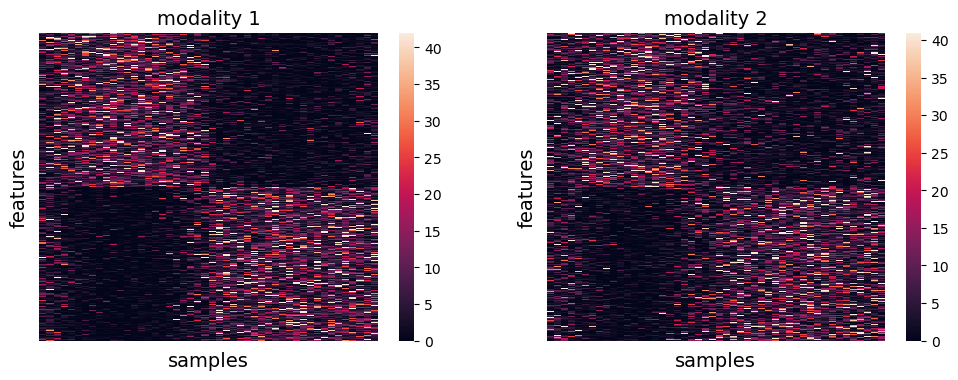

In [24]:
# plot both modalities
fig, axn = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(sim_table1.matrix_data.toarray(), robust=True, 
            ax=axn[0], xticklabels=False, yticklabels=False)

sns.heatmap(sim_table2.matrix_data.toarray(), robust=True, 
            ax=axn[1], xticklabels=False, yticklabels=False)

axn[0].set_ylabel('features', color='black', fontsize=14)
axn[0].set_xlabel('samples', color='black', fontsize=14)
axn[0].set_title('modality 1', color='black', fontsize=14)

axn[1].set_ylabel('features', color='black', fontsize=14)
axn[1].set_xlabel('samples', color='black', fontsize=14)
axn[1].set_title('modality 2', color='black', fontsize=14)
plt.show()

In [25]:
#try joint-ctf
(individual_loadings, 
 feature_loadings, state_loadings, 
 eigenvalues, prop_explained,
 feature_covs) = joint_ctf(tables=[sim_table1, sim_table2], 
                            sample_metadatas=[sim_meta1, sim_meta2],
                            modality_ids=['mod1', 'mod2'],
                            individual_id_column='ind_id',
                            state_column='timepoint')

Calculate components for component_1
Reached convergence in 6 iterations
Calculate components for component_2
Reached convergence in 20 iterations
Calculate components for component_3
Reached convergence in 9 iterations


In [26]:
display(eigenvalues)
display(prop_explained.T)

,component_1,component_2,component_3
mod1,3874.313513,1922.613145,1662.477737
mod2,3076.540911,1515.087687,994.142826


,component_1,component_2,component_3
var_explained,0.541758,0.257392,0.20085


In [27]:
print(state_loadings['mod1'].shape)
display(state_loadings['mod1'])

print(state_loadings['mod2'].shape)
display(state_loadings['mod2'])

(101, 4)


,component_1,component_2,component_3,time_interval
0,0.090849,0.007193,-0.012048,0.00
1,0.091378,0.015591,-0.011726,0.03
2,0.091906,0.023971,-0.011405,0.06
3,0.092432,0.032316,-0.011088,0.09
4,0.092957,0.040607,-0.010777,0.12
...,...,...,...,...
96,0.097964,-0.022455,0.265763,2.88
97,0.097999,-0.020056,0.276914,2.91
98,0.098034,-0.017620,0.288100,2.94
99,0.098071,-0.015159,0.299310,2.97


(101, 4)


,component_1,component_2,component_3,time_interval
0,0.111769,-0.022000,-0.012177,0.00
1,0.111430,-0.020904,-0.011371,0.03
2,0.111090,-0.019813,-0.010570,0.06
3,0.110750,-0.018731,-0.009776,0.09
4,0.110411,-0.017663,-0.008994,0.12
...,...,...,...,...
96,0.098842,0.271823,0.272148,2.88
97,0.099153,0.285307,0.285021,2.91
98,0.099466,0.298839,0.297939,2.94
99,0.099780,0.312403,0.310887,2.97


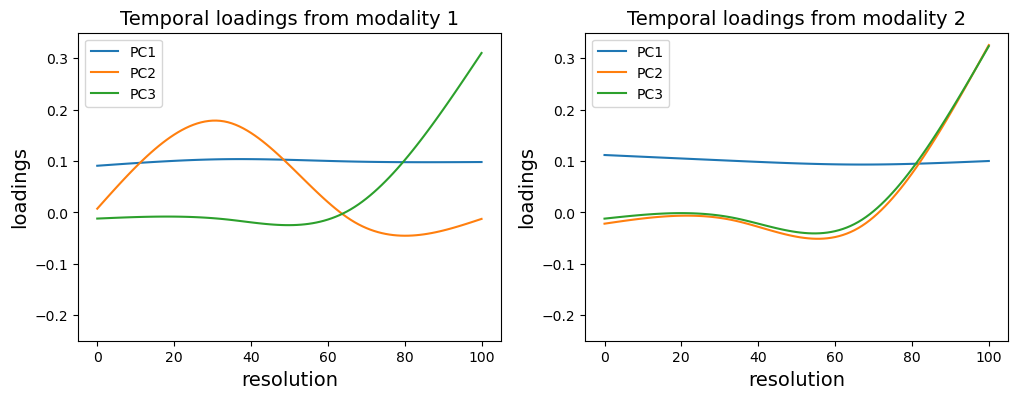

In [28]:
# plot both modalities
fig, axn = plt.subplots(1, 2, figsize=(12, 4))

axn[0].plot(state_loadings['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])

axn[1].plot(state_loadings['mod2'][['component_1', 'component_2', 'component_3']],
            label=['PC1', 'PC2', 'PC3'])

axn[0].set_ylabel('loadings', color='black', fontsize=14)
axn[0].set_xlabel('resolution', color='black', fontsize=14)
axn[0].set_title('Temporal loadings from modality 1', color='black', fontsize=14)
axn[0].set_ylim(-0.25, 0.35)
axn[0].legend()

axn[1].set_ylabel('loadings', color='black', fontsize=14)
axn[1].set_xlabel('resolution', color='black', fontsize=14)
axn[1].set_title('Temporal loadings from modality 2', color='black', fontsize=14)
axn[1].set_ylim(-0.25, 0.35)
axn[1].legend()

plt.show()

In [29]:
print(feature_loadings['mod1'].shape)
display(feature_loadings['mod1'])

print(feature_loadings['mod2'].shape)
display(feature_loadings['mod2'])

(500, 3)


,component_1,component_2,component_3
mod1F0,0.062179,0.028390,0.000022
mod1F1,0.038372,-0.018996,-0.002371
mod1F10,0.027362,0.004295,-0.003108
mod1F100,0.035236,-0.008126,-0.002080
mod1F101,0.057388,-0.032213,-0.002368
...,...,...,...
mod1F95,0.028143,0.076030,0.007052
mod1F96,0.051702,0.071733,-0.003109
mod1F97,0.037978,0.012819,0.006220
mod1F98,0.025165,-0.022070,-0.002864


(500, 3)


,component_1,component_2,component_3
mod2F0,0.042936,0.013032,-0.006042
mod2F1,0.008642,-0.013308,-0.022641
mod2F10,0.056186,-0.014617,-0.004725
mod2F100,0.042113,0.007696,-0.000867
mod2F101,0.033004,-0.011334,0.009469
...,...,...,...
mod2F95,0.080500,-0.024811,0.015240
mod2F96,0.053142,0.069084,-0.005032
mod2F97,0.031355,0.000366,-0.010335
mod2F98,0.033399,-0.012649,-0.008624


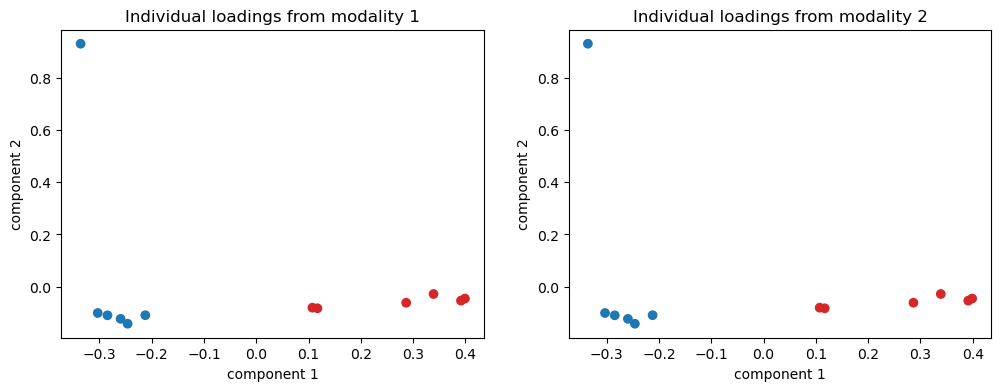

In [30]:
#plot individual loadings from joint-ctf for first 2 components
mf1 = sim_meta1.groupby('ind_id').agg({'group':'first'})
mf2 = sim_meta2.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 2, figsize=(12, 4))
axn[0].scatter(individual_loadings['mod1'][comp1],
               individual_loadings['mod1'][comp2],
               c=mf1['group'].map(group_colors))
axn[0].set_xlabel(comp1.replace('_', ' '))
axn[0].set_ylabel(comp2.replace('_', ' '))
axn[0].set_title('Individual loadings from modality 1')

axn[1].scatter(individual_loadings['mod2'][comp1],
               individual_loadings['mod2'][comp2],
               c=mf2['group'].map(group_colors))
axn[1].set_xlabel(comp1.replace('_', ' '))
axn[1].set_ylabel(comp2.replace('_', ' '))
axn[1].set_title('Individual loadings from modality 2')
plt.show()

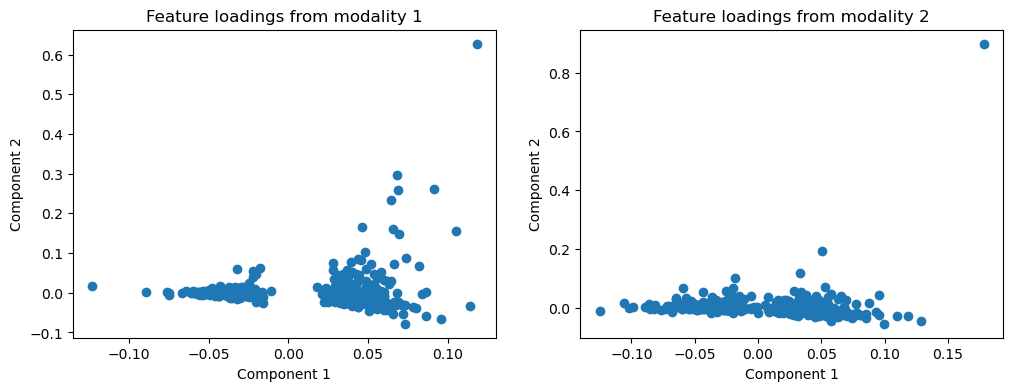

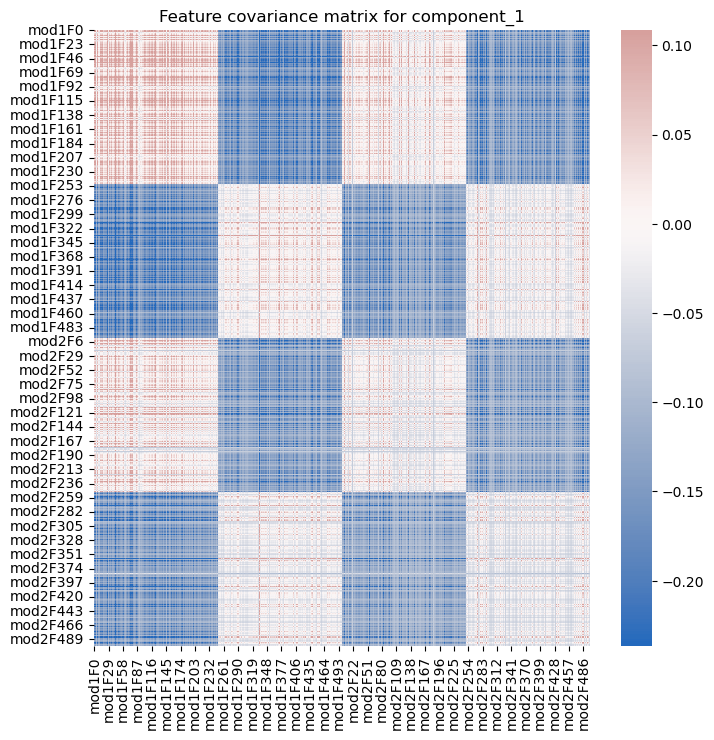

In [41]:
#plot feature loadings from joint-ctf for first 2 components
fig, axn = plt.subplots(1, 2, figsize=(12, 4))
axn[0].scatter(feature_loadings['mod1']['component_1'],
               feature_loadings['mod1']['component_2'])
axn[0].set_xlabel('Component 1')
axn[0].set_ylabel('Component 2')
axn[0].set_title('Feature loadings from modality 1')

axn[1].scatter(feature_loadings['mod2']['component_1'],
               feature_loadings['mod2']['component_2'])
axn[1].set_xlabel('Component 1')
axn[1].set_ylabel('Component 2')
axn[1].set_title('Feature loadings from modality 2')
plt.show()

#get feature cov matrix and reorder IDs
feature_order1 = sim_table1.ids(axis='observation').tolist()
feature_order2 = sim_table2.ids(axis='observation').tolist()
feature_order = feature_order1 + feature_order2

component = 'component_1'
cov_table = feature_covs[component]
cov_table = cov_table.loc[feature_order, feature_order]

#plot heatmap of feature covariance matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cov_table, robust=True, cmap='vlag', center=0)
plt.title('Feature covariance matrix for {}'.format('component_1'))
plt.show()

In [ ]:
# # create ordination results
# short_method_name = 'joint_ctf_biplot'
# long_method_name = 'Individual level biplot'

# #modality 1
# individual_loadings['mod1'].index = individual_loadings['mod1'].index.astype(str)
# feature_loadings['mod1'].index = feature_loadings['mod1'].index.astype(str)
# individual_ord1 = OrdinationResults(short_method_name,
#                                    long_method_name,
#                                    eigenvalues.loc['mod1'],
#                                    samples=individual_loadings['mod1'],
#                                    features=feature_loadings['mod1'],
#                                    proportion_explained=prop_explained.values)
# mf1 = sim_meta1.groupby('ind_id').agg({'group':'first'})
# mf1.index.name = '#SampleID'
# mf1.index = mf1.index.astype(str)

# #modality 2
# individual_loadings['mod2'].index = individual_loadings['mod2'].index.astype(str)
# feature_loadings['mod2'].index = feature_loadings['mod2'].index.astype(str)
# individual_ord2 = OrdinationResults(short_method_name,
#                                    long_method_name,
#                                    eigenvalues.loc['mod2'],
#                                    samples=individual_loadings['mod2'],
#                                    features=feature_loadings['mod2'],
#                                    proportion_explained=prop_explained.values)
# mf2 = sim_meta2.groupby('ind_id').agg({'group':'first'})
# mf2.index.name = '#SampleID'
# mf2.index = mf2.index.astype(str)

In [ ]:
# Emperor(individual_ord1, mf1, dimensions=15).set_axes(color='black').color_by('group')

In [ ]:
# Emperor(individual_ord2, mf2, dimensions=15).set_axes(color='black').color_by('group')